# Project: Guessing the likelihood of showing up to the doctor's appointment from just basic info:



## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#Assess">Assess</a></li>
<li><a href="#cleaning">Cleaning</a></li>
<li><a href="#wrangle">Data Wrangling and Feature Engineering</a></li>   
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#Learning">Machine Learning</a></li>
<li><a href="#conc">Conclusions</a></li>

---------------

## Introduction <a id='intro'></a>

> We have a database of almost 110000 records of doctor's appointment and with the aid of cleaning, wrangling and then feature engineering we will be able to find a lot of insights, what features increase the likelihood of showing up the most and definately train an algorithm to efficiently predict the No show parameter when given a set of info about the patient and the appointment date.

In [560]:
import numpy as np
import pandas as pd
from fuzzywuzzy import process, fuzz
import warnings

In [561]:
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline()

%matplotlib inline
pd.set_option('display.max_columns', None)

----------------

## Data Assessing <a id='Assess'></a>

In [562]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.sample(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
12504,6.353920e+13,5692318,M,2016-05-12T14:59:56Z,2016-05-19T00:00:00Z,39,ILHA DE SANTA MARIA,0,0,0,0,0,0,Yes
28768,2.234249e+12,5734088,F,2016-05-24T14:52:16Z,2016-05-30T00:00:00Z,34,ROMÃO,1,0,0,0,0,1,Yes
60411,4.769462e+14,5609301,F,2016-04-20T15:33:43Z,2016-05-19T00:00:00Z,0,MARIA ORTIZ,0,0,0,0,0,0,Yes
86688,8.662268e+10,5750765,F,2016-05-31T09:17:28Z,2016-06-07T00:00:00Z,69,BONFIM,0,1,0,0,0,1,No
108049,2.852923e+14,5759369,F,2016-06-01T12:37:14Z,2016-06-01T00:00:00Z,2,SANTO ANTÔNIO,0,0,0,0,0,0,No


* 'PatientId' is scientific and this needs to be changed.
* Rename 'Scolarship' to 'Bolsa Família' since it's easier to search for. 
* Rename 'AppointmentID' to 'AppointmentId'.
* Rename 'SMS_received' to 'ReceivedText'
* Rename 'No-show' to 'ٍShowedUp'.
* 'Neighbourhood' has its info all capped which reduces readability.

In [563]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


* 'PatientId' and 'AppointmentID' data types need to be (Str).
* 'ScheduledDay' and 'AppointmentDay' data types need to be (Daytime).
* 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received' and 'No-show' data types need to be (Boolean).
* 'Gender' and 'Neighbourhood' should be categoral

In [564]:
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

* We can see that patients had multiple visits and that's why 'PatientId' is less than (110527).
* 'Handcap' column has 5 values although it should be only 2 so this needs to be fixed.

In [565]:
df.Handcap.value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

* As mentioned, seems like the numbers refer to different types of handicapcy or maybe it's a typo.

In [566]:
df.Age.max()

115

In [567]:
df.Age.min()

-1

* Most propably this is a typo and it will be fixed.

In [568]:
df[df.Age == df.Age.min()]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


In [569]:
df.Age.sort_values().tail(10)

79272     100
108506    100
92084     100
90372     102
58014     102
63915     115
76284     115
68127     115
63912     115
97666     115
Name: Age, dtype: int64

In [570]:
df[df.Age == df.Age.max()]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
63912,3.196321e+13,5700278,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
63915,3.196321e+13,5700279,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
68127,3.196321e+13,5562812,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,3.196321e+13,5744037,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,No
97666,7.482346e+14,5717451,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,115,SÃO JOSÉ,0,1,0,0,0,1,No


* Checking for Age outliers but everything seems fine.

In [571]:
uniques = (df.Neighbourhood.value_counts())

In [572]:
ratios = pd.DataFrame(index=uniques.index, columns=uniques.index)

In [573]:
for x in uniques.index:
    for y in uniques.index:
        ratios.loc[x][y] = fuzz.ratio(x,y)

In [574]:
for x in ratios.columns:
    y = ratios[x].sort_values(ascending=False).head(5)
    print('\n{} \n'.format(y))


JARDIM CAMBURI       100
PONTAL DE CAMBURI     65
MORADA DE CAMBURI     58
JARDIM DA PENHA       55
DO CABRAL             52
Name: JARDIM CAMBURI, dtype: object 


MARIA ORTIZ       100
AEROPORTO          50
MATA DA PRAIA      50
VILA RUBIM         48
MÁRIO CYPRESTE     48
Name: MARIA ORTIZ, dtype: object 


RESISTÊNCIA          100
PARQUE INDUSTRIAL     50
REPÚBLICA             50
BELA VISTA            48
ESTRELINHA            48
Name: RESISTÊNCIA, dtype: object 


JARDIM DA PENHA    100
DA PENHA            70
JARDIM CAMBURI      55
MATA DA PRAIA       50
ANDORINHAS          48
Name: JARDIM DA PENHA, dtype: object 


ITARARÉ        100
CARATOÍRA       50
GOIABEIRAS      47
TABUAZEIRO      47
SANTA CLARA     44
Name: ITARARÉ, dtype: object 


CENTRO          100
CRUZAMENTO       62
SÃO BENEDITO     44
REDENÇÃO         43
AEROPORTO        40
Name: CENTRO, dtype: object 


TABUAZEIRO    100
GOIABEIRAS     50
AEROPORTO      42
DO QUADRO      42
CENTRO         38
Name: TABUAZEIRO, dtype: 

* In the above few cells, checking for multiple neighbors that might be the same but containing a typo but luckily there is none.

In [575]:
df.ScheduledDay.value_counts()

2016-05-06T07:09:54Z    24
2016-05-06T07:09:53Z    23
2016-04-25T17:18:27Z    22
2016-04-25T17:17:46Z    22
2016-04-25T17:17:23Z    19
                        ..
2016-05-20T11:30:24Z     1
2016-05-11T10:26:11Z     1
2016-04-26T12:11:49Z     1
2016-04-29T10:09:17Z     1
2016-05-31T15:50:51Z     1
Name: ScheduledDay, Length: 103549, dtype: int64

* We need to remove the (T) and (Z) from each line.

In [576]:
df.AppointmentDay.value_counts()

2016-06-06T00:00:00Z    4692
2016-05-16T00:00:00Z    4613
2016-05-09T00:00:00Z    4520
2016-05-30T00:00:00Z    4514
2016-06-08T00:00:00Z    4479
2016-05-11T00:00:00Z    4474
2016-06-01T00:00:00Z    4464
2016-06-07T00:00:00Z    4416
2016-05-12T00:00:00Z    4394
2016-05-02T00:00:00Z    4376
2016-05-18T00:00:00Z    4373
2016-05-17T00:00:00Z    4372
2016-06-02T00:00:00Z    4310
2016-05-10T00:00:00Z    4308
2016-05-31T00:00:00Z    4279
2016-05-05T00:00:00Z    4273
2016-05-19T00:00:00Z    4270
2016-05-03T00:00:00Z    4256
2016-05-04T00:00:00Z    4168
2016-06-03T00:00:00Z    4090
2016-05-24T00:00:00Z    4009
2016-05-13T00:00:00Z    3987
2016-05-25T00:00:00Z    3909
2016-05-06T00:00:00Z    3879
2016-05-20T00:00:00Z    3828
2016-04-29T00:00:00Z    3235
2016-05-14T00:00:00Z      39
Name: AppointmentDay, dtype: int64

* Time is always (00:00:00) so we can safely remove it.

----------------------------------

## Data Cleaning  <a id='cleaning'></a>

In [577]:
df_c = df.copy()

* Creating a copy of the DataFrame.

##### Removing the all Cap.

In [665]:
df_c.Neighbourhood = df_c.Neighbourhood.apply(lambda x:x.title())

##### Renaming Columns

In [579]:
df_c.rename(columns={"Scholarship": "BolsaFamilia", "AppointmentID": "AppointmentId", "SMS_received": "ReceivedText", 'No-show':'ShowedUp'},inplace=True)

##### Fixing 'PatientId' values

In [580]:
df_c.PatientId = df_c.PatientId.apply(lambda x:int(x))

##### Changing Dtypes

In [581]:
df_c.PatientId = df_c.PatientId.astype('str')
df_c.AppointmentId = df_c.AppointmentId.astype('str')

In [582]:
df_c.Gender = df_c.Gender.astype('category')
df_c.Neighbourhood = df_c.Neighbourhood.astype('category')

In [583]:
df_c.AppointmentDay = df_c.AppointmentDay.apply(lambda x: x.split('T')[0])

In [584]:
df_c.ScheduledDay = df_c.ScheduledDay.apply(lambda x:x.replace('T',' '))
df_c.ScheduledDay = df_c.ScheduledDay.apply(lambda x:x.replace('Z',''))

In [585]:
df_c.ScheduledDay = pd.to_datetime(df_c['ScheduledDay'])

In [586]:
df_c.AppointmentDay = pd.to_datetime(df_c['AppointmentDay'])

In [587]:
def change_to_bool(x):
    if ((x == 'No') or (x == 0)):
        return 0
    else:
        return 1

In [588]:
def exchange01(x):
    if x=='No':
        return 1
    if x=='Yes':
        return 0

In [589]:
df_c.ShowedUp = df_c.ShowedUp.apply(exchange01)

In [590]:
df_c.Handcap = df_c.Handcap.apply(change_to_bool)

In [591]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PatientId       110527 non-null  object        
 1   AppointmentId   110527 non-null  object        
 2   Gender          110527 non-null  category      
 3   ScheduledDay    110527 non-null  datetime64[ns]
 4   AppointmentDay  110527 non-null  datetime64[ns]
 5   Age             110527 non-null  int64         
 6   Neighbourhood   110527 non-null  category      
 7   BolsaFamilia    110527 non-null  int64         
 8   Hipertension    110527 non-null  int64         
 9   Diabetes        110527 non-null  int64         
 10  Alcoholism      110527 non-null  int64         
 11  Handcap         110527 non-null  int64         
 12  ReceivedText    110527 non-null  int64         
 13  ShowedUp        110527 non-null  int64         
dtypes: category(2), datetime64[ns](2), i

##### Fix Age outlier

In [666]:
df_c[df_c.Age == -1]

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,BolsaFamilia,Hipertension,Diabetes,Alcoholism,Handcap,ReceivedText,ShowedUp,ScheduledDayOfWeek,AppointmentDayOfWeek,ScheduledMonth,AppointmentMonth,ScheduledDayInMonth,AppointmentDayInMonth,DaysDifference,ScheduledWeekInMonth,AppointmentWeekInMonth,ScheduledHour,NumberOfConditions,Suffering


In [593]:
all_0 = df_c[(df_c.BolsaFamilia + df_c.Hipertension + df_c.Diabetes + df_c.Alcoholism + df_c.Handcap) == 0]

In [594]:
df_c.Age.iloc[99832] = int(all_0.Age.mode())

******************

## Data Wrangling and Feature Engineering <a id='wrangle'></a>

In order to find more insights we need to create more columns from the data we have and this includes:
* The day of the week for both shceduled and appointment. 
* The month for both shceduled and appointment. 
* Which week in the month for both shceduled and appointment. 
* Which day in the month for both shceduled and appointment. 
* The hour of schedule. 
* Is the patient suffering from [Hipertension Diabetes Alcoholism Handcap] or not. 
* How many conditions does the patient suffer from.
* Difference between schedule day and appointment day.

In [595]:
df_c['ScheduledDayOfWeek'] = df_c.ScheduledDay.dt.day_name().astype('category')
df_c['AppointmentDayOfWeek'] = df_c.AppointmentDay.dt.day_name().astype('category')

In [596]:
df_c['ScheduledMonth'] = df_c.ScheduledDay.dt.month_name().astype('category')
df_c['AppointmentMonth'] = df_c.AppointmentDay.dt.month_name().astype('category')

In [597]:
df_c['ScheduledDayInMonth'] = df_c.ScheduledDay.dt.day
df_c['AppointmentDayInMonth'] = df_c.AppointmentDay.dt.day

In [598]:
df_c['DaysDifference'] = df_c.AppointmentDay.dt.dayofyear - df_c.ScheduledDay.dt.dayofyear

In [599]:
def WeekOfMonth(x):
    if ((x > 0) and (x <= 7)):
        return(1)
    
    if ((x > 7) and (x <= 14)):
        return(2)
    
    if ((x > 14) and (x <= 21)):
        return(3)
    
    if ((x > 21) and (x <= 28)):
        return(4)
    
    else:
        return(5)

In [600]:
df_c['ScheduledWeekInMonth'] = df_c.ScheduledDayInMonth.apply(WeekOfMonth)
df_c['AppointmentWeekInMonth'] = df_c.AppointmentDayInMonth.apply(WeekOfMonth)

In [601]:
df_c['ScheduledHour'] = df_c.ScheduledDay.dt.hour

In [602]:
df_c['NumberOfConditions'] = df_c[['Hipertension', 'Diabetes', 'Alcoholism', 'Handcap']].sum(1)
df_c

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,BolsaFamilia,Hipertension,Diabetes,Alcoholism,Handcap,ReceivedText,ShowedUp,ScheduledDayOfWeek,AppointmentDayOfWeek,ScheduledMonth,AppointmentMonth,ScheduledDayInMonth,AppointmentDayInMonth,DaysDifference,ScheduledWeekInMonth,AppointmentWeekInMonth,ScheduledHour,NumberOfConditions
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,Jardim Da Penha,0,1,0,0,0,0,1,Friday,Friday,April,April,29,29,0,5,5,18,1
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,Jardim Da Penha,0,0,0,0,0,0,1,Friday,Friday,April,April,29,29,0,5,5,16,0
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,Mata Da Praia,0,0,0,0,0,0,1,Friday,Friday,April,April,29,29,0,5,5,16,0
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,Pontal De Camburi,0,0,0,0,0,0,1,Friday,Friday,April,April,29,29,0,5,5,17,0
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,Jardim Da Penha,0,1,1,0,0,0,1,Friday,Friday,April,April,29,29,0,5,5,16,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293,5651768,F,2016-05-03 09:15:35,2016-06-07,56,Maria Ortiz,0,0,0,0,0,1,1,Tuesday,Tuesday,May,June,3,7,35,1,1,9,0
110523,3596266328735,5650093,F,2016-05-03 07:27:33,2016-06-07,51,Maria Ortiz,0,0,0,0,0,1,1,Tuesday,Tuesday,May,June,3,7,35,1,1,7,0
110524,15576631729893,5630692,F,2016-04-27 16:03:52,2016-06-07,21,Maria Ortiz,0,0,0,0,0,1,1,Wednesday,Tuesday,April,June,27,7,41,4,1,16,0
110525,92134931435557,5630323,F,2016-04-27 15:09:23,2016-06-07,38,Maria Ortiz,0,0,0,0,0,1,1,Wednesday,Tuesday,April,June,27,7,41,4,1,15,0


In [603]:
df_c['Suffering'] = df_c.NumberOfConditions.apply(change_to_bool)

In [604]:
df_c.sample(5)

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,BolsaFamilia,Hipertension,Diabetes,Alcoholism,Handcap,ReceivedText,ShowedUp,ScheduledDayOfWeek,AppointmentDayOfWeek,ScheduledMonth,AppointmentMonth,ScheduledDayInMonth,AppointmentDayInMonth,DaysDifference,ScheduledWeekInMonth,AppointmentWeekInMonth,ScheduledHour,NumberOfConditions,Suffering
10025,83271796136194,5659517,F,2016-05-04 14:07:42,2016-05-04,17,Romão,0,0,0,0,0,0,1,Wednesday,Wednesday,May,May,4,4,0,1,1,14,0,0
6675,716571673724283,5722968,F,2016-05-20 07:49:21,2016-05-24,40,Nova Palestina,1,1,0,0,0,1,0,Friday,Tuesday,May,May,20,24,4,3,4,7,1,1
1068,723761596624,5640531,F,2016-04-29 10:53:46,2016-04-29,16,Bela Vista,1,0,0,0,0,0,1,Friday,Friday,April,April,29,29,0,5,5,10,0,0
28626,386678155397,5695052,M,2016-05-13 09:24:36,2016-05-20,3,Forte São João,0,0,0,0,0,0,1,Friday,Friday,May,May,13,20,7,2,3,9,0,0
97631,962199499979687,5700002,F,2016-05-16 09:02:02,2016-06-08,43,Santo Antônio,0,0,0,0,0,1,1,Monday,Wednesday,May,June,16,8,23,3,2,9,0,0


In [605]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   PatientId               110527 non-null  object        
 1   AppointmentId           110527 non-null  object        
 2   Gender                  110527 non-null  category      
 3   ScheduledDay            110527 non-null  datetime64[ns]
 4   AppointmentDay          110527 non-null  datetime64[ns]
 5   Age                     110527 non-null  int64         
 6   Neighbourhood           110527 non-null  category      
 7   BolsaFamilia            110527 non-null  int64         
 8   Hipertension            110527 non-null  int64         
 9   Diabetes                110527 non-null  int64         
 10  Alcoholism              110527 non-null  int64         
 11  Handcap                 110527 non-null  int64         
 12  ReceivedText            110527

-------------

## Exploratory Data Analysis<a id='eda'></a>

Now that we've trimmed and cleaned our data, we're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that we posed in the Introduction section.

In [606]:
df_c.groupby(['Gender','ShowedUp'])['ShowedUp'].count()

Gender  ShowedUp
F       0           14594
        1           57246
M       0            7725
        1           30962
Name: ShowedUp, dtype: int64

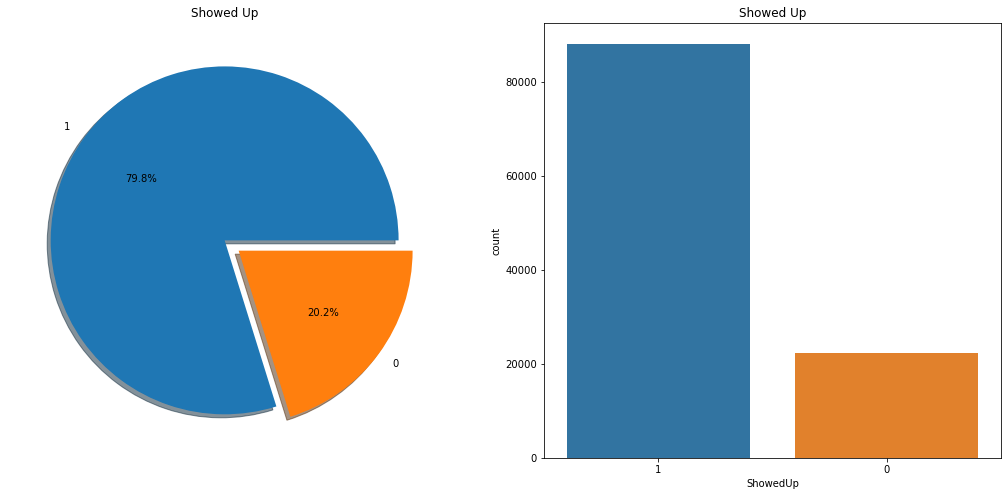

In [607]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df_c['ShowedUp'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Showed Up')
ax[0].set_ylabel('')
sns.countplot('ShowedUp',data=df_c,ax=ax[1],order=[1,0])
ax[1].set_title('Showed Up')
plt.show()

The data provided tells us that only one fifth of the patients miss their appointment and from here we will study what factors increase the occurance of no show.

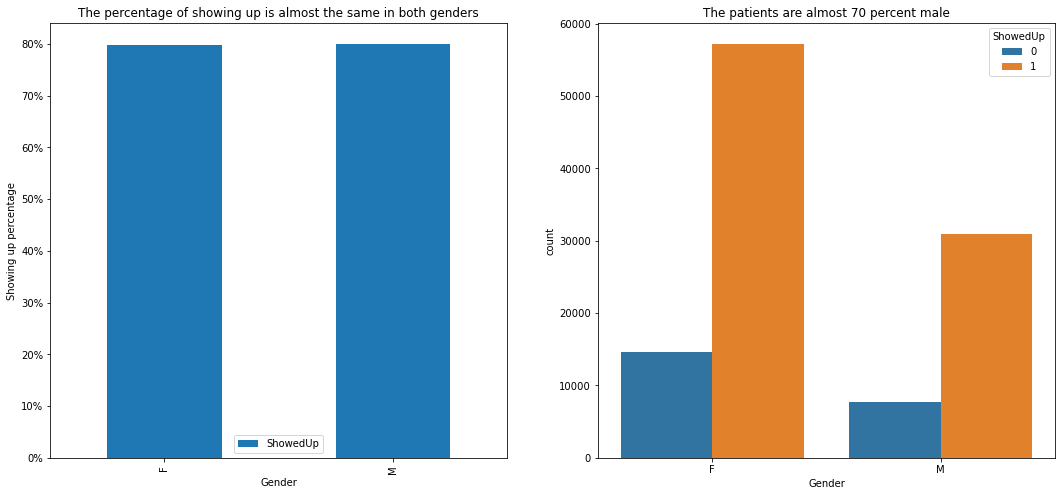

In [608]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df_c[['Gender','ShowedUp']].groupby(['Gender']).mean().plot.bar(ax=ax[0])
ax[0].set_title('The percentage of showing up is almost the same in both genders')
ax[0].set_ylabel('Showing up percentage')
sns.countplot('Gender',hue='ShowedUp',data=df_c,ax=ax[1])
ax[1].set_title('The patients are almost 70 percent male')
vals = ax[0].get_yticks()
ax[0].set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()

I was kind of thinking that Gender will be a culprit whether the patient misses his/her oppointment or not, but the numbers says that it doesn't at all.

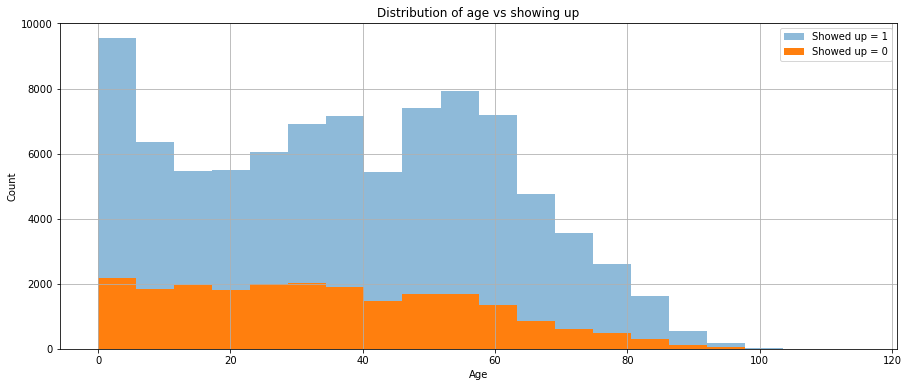

In [609]:
plt.figure(figsize=(15,6))
ax = df_c[df_c.ShowedUp == 1].Age.hist(bins=20,alpha=0.5,label='Showed up = 1')
df_c[df_c.ShowedUp == 0].Age.hist(bins=20,label='Showed up = 0')
ax.set_ylabel('Count')
ax.set_xlabel('Age')
ax.set_title('Distribution of age vs showing up')
plt.legend();

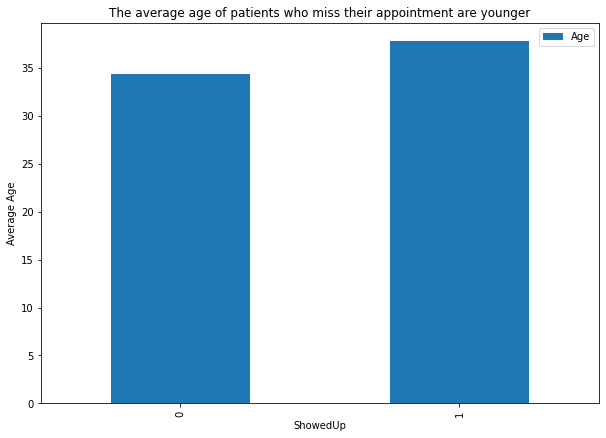

In [610]:
plt.rcParams["figure.figsize"] = (10,7)
ax = df_c[['Age','ShowedUp']].groupby(['ShowedUp']).mean().plot.bar()
plt.title('The average age of patients who miss their appointment are younger')

ax.set_ylabel('Average Age');

So although the difference isn't that big but age is the first notable factor affecting missing the appointments since older patients are more likely to show up.

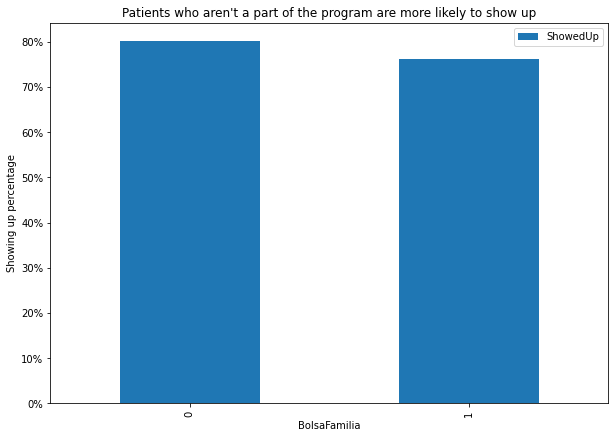

In [611]:
plt.rcParams["figure.figsize"] = (10,7)
ax = df_c[['BolsaFamilia','ShowedUp']].groupby(['BolsaFamilia']).mean().plot.bar()
plt.title("Patients who aren't a part of the program are more likely to show up")
ax.set_ylabel('Showing up percentage')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

Patients who are included in the social aid Bolsa Familia are more likely to miss their appointment which makes sense since their reservation might be completely free or at least really discounted.

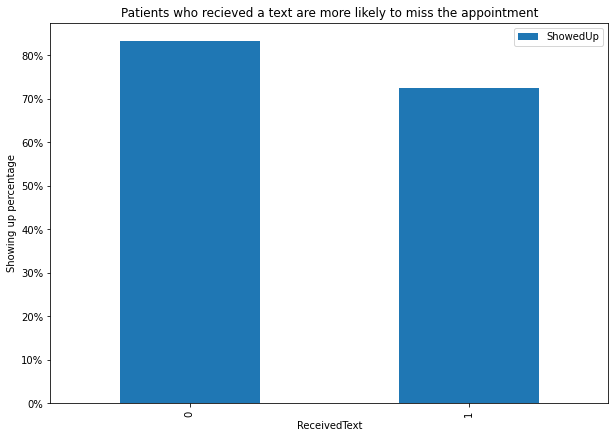

In [612]:
plt.rcParams["figure.figsize"] = (10,7)
ax = df_c[['ReceivedText','ShowedUp']].groupby(['ReceivedText']).mean().plot.bar()
plt.title("Patients who recieved a text are more likely to miss the appointment")
ax.set_ylabel('Showing up percentage')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

In [613]:
df_c.ReceivedText.value_counts()

0    75045
1    35482
Name: ReceivedText, dtype: int64

In [614]:
df_c[['ReceivedText','BolsaFamilia']].groupby('BolsaFamilia').ReceivedText.value_counts()

BolsaFamilia  ReceivedText
0             0               67689
              1               31977
1             0                7356
              1                3505
Name: ReceivedText, dtype: int64

Out of all the insights we got, this is the one who strikes me the most.
Patients who got notified with a SMS missed their visit more and by a big 10 percent which is the most notable difference so far.
However looking at how many patients recieved the SMS which is only one third of the total, it seems like this text is sent when the patient is late or something like that.
This data has a lot of records and a trend like this can't be neglected espcially that why not send the SMS to all patients and hence there must be a reason for the text.

Another speculation is that maybe not everyone has a cellphone, but looking at the financial aid in relation to recieved text but the numbers didn't show any relation

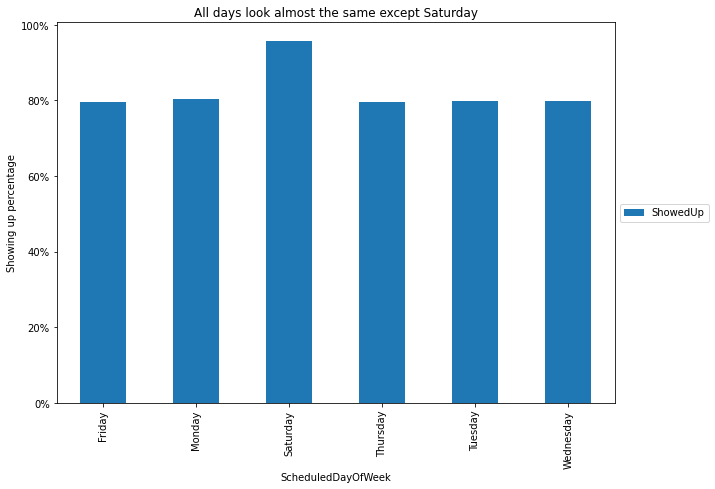

In [615]:
plt.rcParams["figure.figsize"] = (10,7)
ax = df_c[['ScheduledDayOfWeek','ShowedUp']].groupby(['ScheduledDayOfWeek']).mean().plot.bar()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.title("All days look almost the same except Saturday");
ax.set_ylabel('Showing up percentage')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

Upon further inspection Saturday got only 24 appointments which 23 of them where no show however due to the low number of records it can be taken with a grain of salt.

Next would be some graphs to different time conditions the most notable was scheduled month being June which has a huge advantage to get the patient to show up.

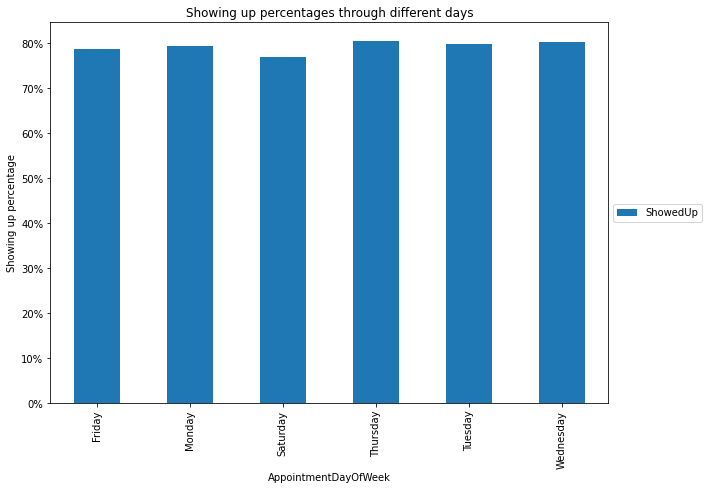

In [616]:
ax = df_c[['AppointmentDayOfWeek','ShowedUp']].groupby(['AppointmentDayOfWeek']).mean().plot.bar()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_ylabel('Showing up percentage')
vals = ax.get_yticks()
ax.set_title('Showing up percentages through different days')
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

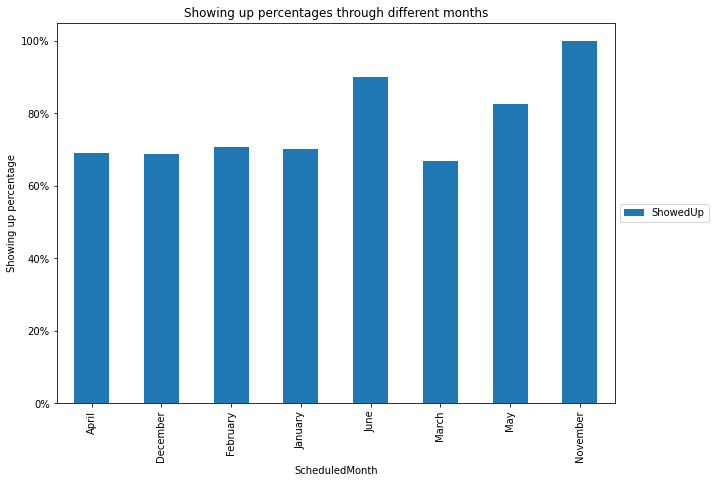

In [617]:
plt.rcParams["figure.figsize"] = (10,7)
ax = df_c[['ScheduledMonth','ShowedUp']].groupby(['ScheduledMonth']).mean().plot.bar()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_ylabel('Showing up percentage')
ax.set_title('Showing up percentages through different months')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

In [618]:
df_c[df_c.ScheduledMonth == 'November']

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,BolsaFamilia,Hipertension,Diabetes,Alcoholism,Handcap,ReceivedText,ShowedUp,ScheduledDayOfWeek,AppointmentDayOfWeek,ScheduledMonth,AppointmentMonth,ScheduledDayInMonth,AppointmentDayInMonth,DaysDifference,ScheduledWeekInMonth,AppointmentWeekInMonth,ScheduledHour,NumberOfConditions,Suffering
3764,832256398961987,5030230,F,2015-11-10 07:13:56,2016-05-04,51,Resistência,0,0,0,0,0,1,1,Tuesday,Wednesday,November,May,10,4,-189,2,1,7,0,0


November has a 100% showing up rate but it has only one occurance, but when it comes to June a real trend can be seen, if the patient schedualed on June it's more likely it will be a show up when compared to other months.


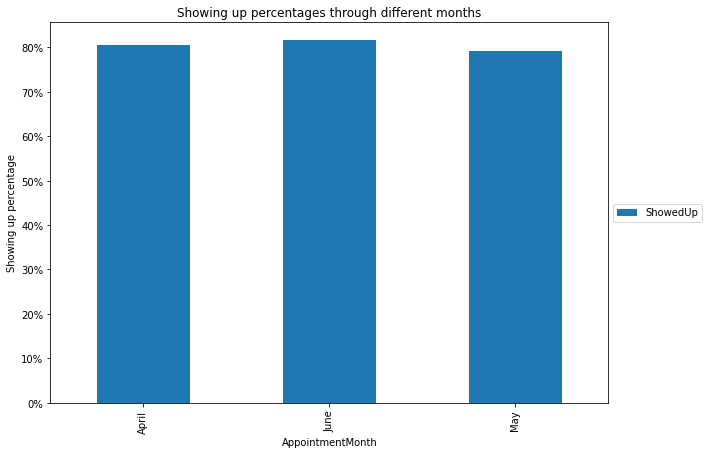

In [619]:
plt.rcParams["figure.figsize"] = (10,7)
ax = df_c[['AppointmentMonth','ShowedUp']].groupby(['AppointmentMonth']).mean().plot.bar()
ax.set_title('Showing up percentages through different months')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_ylabel('Showing up percentage')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

Differances are minimal here

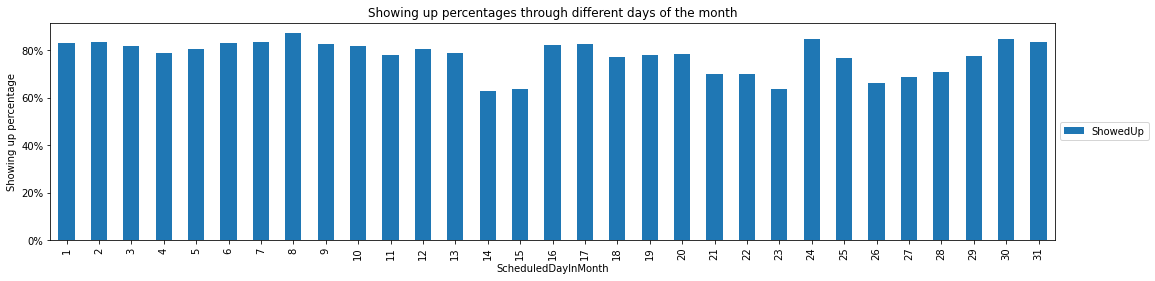

In [620]:
plt.rcParams["figure.figsize"] = (18,4)
ax = df_c[['ScheduledDayInMonth','ShowedUp']].groupby(['ScheduledDayInMonth']).mean().plot.bar();
ax.set_title('Showing up percentages through different days of the month')
ax.set_ylabel('Showing up percentage')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

We can definately see a wave pattern here which shows the effect of which day in the week it is.
Each day of the month has the around the same probability if we decrease or increas 7 days most of the time


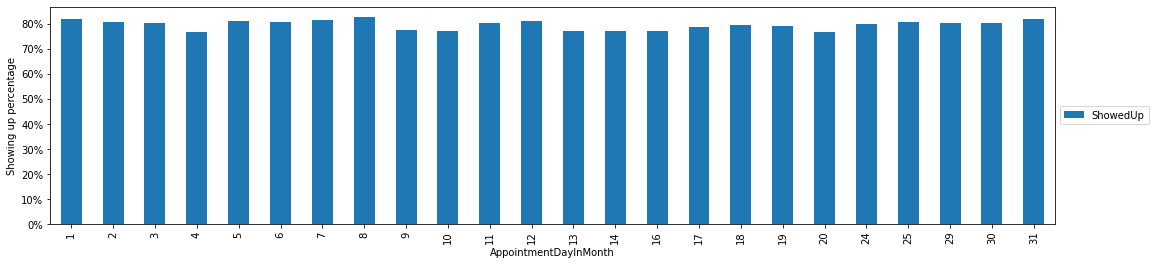

In [621]:
plt.rcParams["figure.figsize"] = (18,4)
ax = df_c[['AppointmentDayInMonth','ShowedUp']].groupby(['AppointmentDayInMonth']).mean().plot.bar();
ax.set_ylabel('Showing up percentage')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

it's actually weird that the scheduale day is more affecting than the appointing day itself

In [622]:
df_c[df_c.ScheduledDayOfWeek == 'Saturday'].ShowedUp.value_counts()

1    23
0     1
Name: ShowedUp, dtype: int64

In [623]:
df_c[df_c.ScheduledMonth == 'June'].ShowedUp.value_counts()

1    12364
0     1386
Name: ShowedUp, dtype: int64

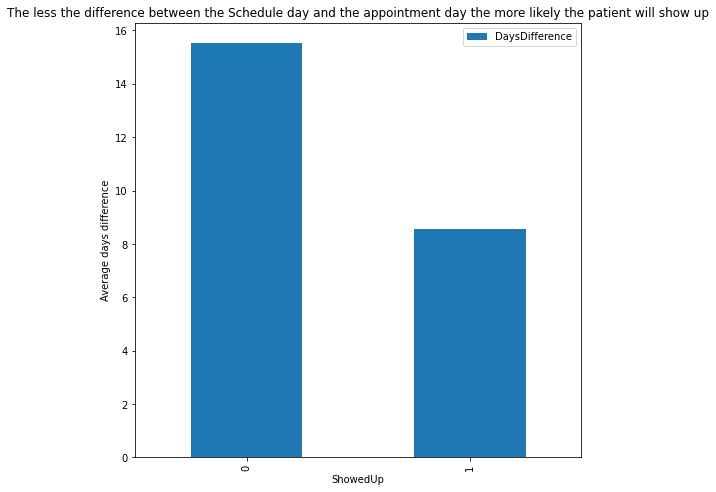

In [624]:
plt.rcParams["figure.figsize"] = (8,8)
ax = df_c[['DaysDifference','ShowedUp']].groupby(['ShowedUp']).mean().plot.bar();
plt.title("The less the difference between the Schedule day and the appointment day the more likely the patient will show up");
ax.set_ylabel('Average days difference');

This is a no brainer the less the days difference between the reserving and the appointment itself, the more likely the patient would show up.

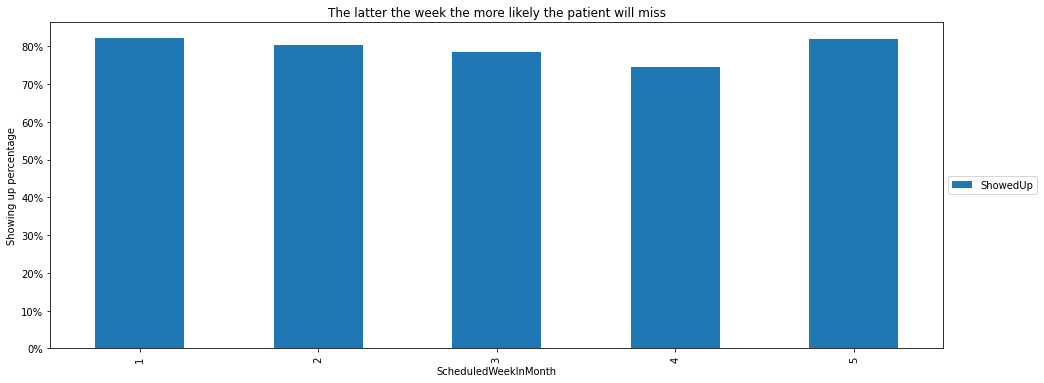

In [625]:
plt.rcParams["figure.figsize"] = (16,6)
ax = df_c[['ScheduledWeekInMonth','ShowedUp']].groupby(['ScheduledWeekInMonth']).mean().plot.bar();
ax.set_ylabel('Showing up percentage')
vals = ax.get_yticks()
plt.title("The latter the week the more likely the patient will miss");
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

The later the appointment in the month the more likely to miss the appointment except for the last few days of each month showing up rises again.

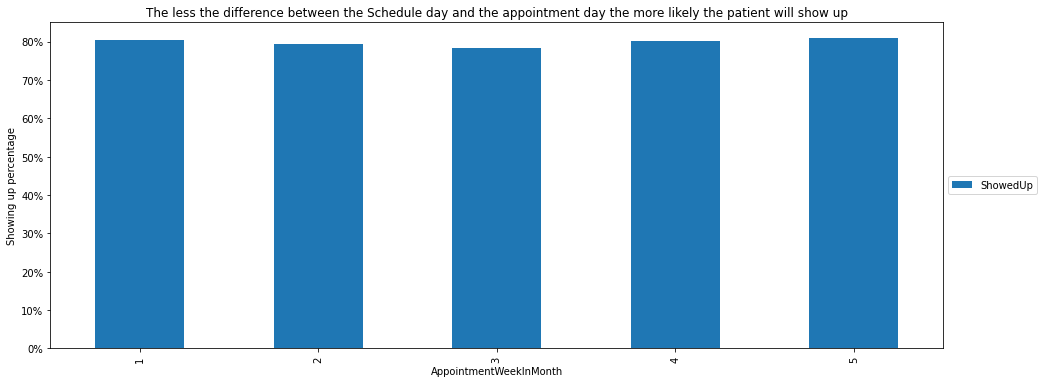

In [626]:
plt.rcParams["figure.figsize"] = (16,6)
ax = df_c[['AppointmentWeekInMonth','ShowedUp']].groupby(['AppointmentWeekInMonth']).mean().plot.bar();
ax.set_ylabel('Showing up percentage')
plt.title("The less the difference between the Schedule day and the appointment day the more likely the patient will show up");
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

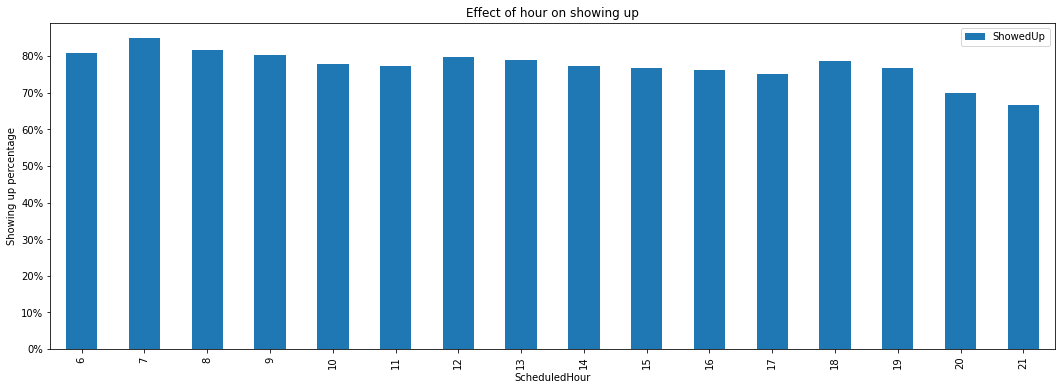

In [627]:
plt.rcParams["figure.figsize"] = (18,6)
ax = df_c[['ScheduledHour','ShowedUp']].groupby(['ScheduledHour']).mean().plot.bar();
ax.set_ylabel('Showing up percentage')
vals = ax.get_yticks()
plt.title("Effect of hour on showing up");
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

Time of day definately has an effect and we can see it's almost right skewed

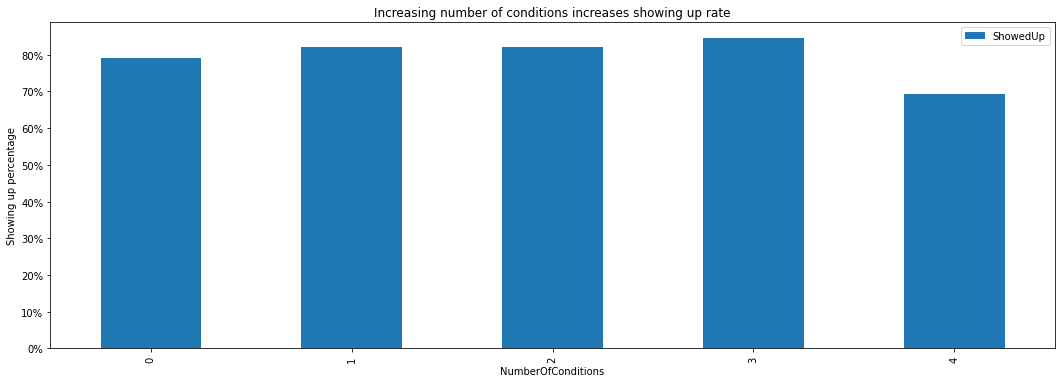

In [628]:
plt.rcParams["figure.figsize"] = (18,6)
ax = df_c[['NumberOfConditions','ShowedUp']].groupby(['NumberOfConditions']).mean().plot.bar();
ax.set_ylabel('Showing up percentage')
plt.title("Increasing number of conditions increases showing up rate");
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

The higher the number of conditions the more the patient would need the appointment and this is shown really well here we can see a pattern, but still this pattern changes when customers have all 4 conditions.

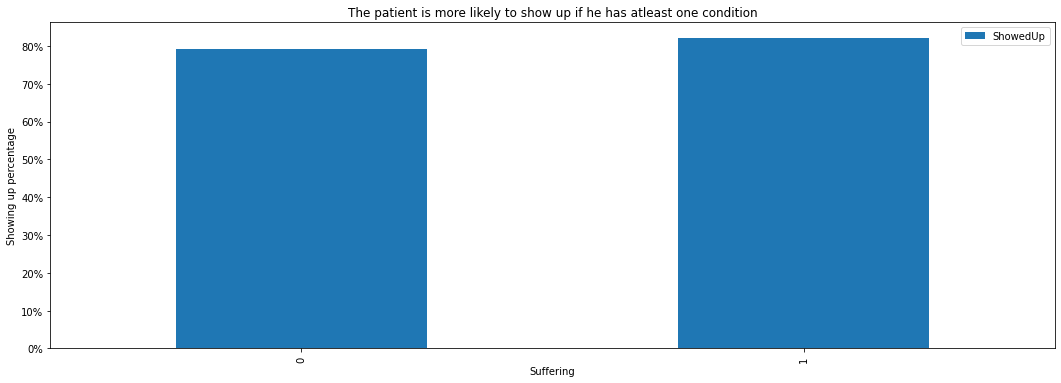

In [629]:
plt.rcParams["figure.figsize"] = (18,6)
ax = df_c[['Suffering','ShowedUp']].groupby(['Suffering']).mean().plot.bar();
ax.set_ylabel('Showing up percentage')
plt.title("The patient is more likely to show up if he has atleast one condition");
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

Same as previously the patient shows up more if he has a condition.

-----------

## Machine Learning <a id='Learning'></a>

In [630]:
df_m = df_c.copy()

In [631]:
df_m.head(1)

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,BolsaFamilia,Hipertension,Diabetes,Alcoholism,Handcap,ReceivedText,ShowedUp,ScheduledDayOfWeek,AppointmentDayOfWeek,ScheduledMonth,AppointmentMonth,ScheduledDayInMonth,AppointmentDayInMonth,DaysDifference,ScheduledWeekInMonth,AppointmentWeekInMonth,ScheduledHour,NumberOfConditions,Suffering
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,Jardim Da Penha,0,1,0,0,0,0,1,Friday,Friday,April,April,29,29,0,5,5,18,1,1


In [632]:
df_m.drop(columns=['PatientId','AppointmentId','ScheduledDay','AppointmentDay'],inplace=True)

In [633]:
Male = pd.get_dummies(df_m.Gender,drop_first=True)

In [634]:
df_m.Gender = Male

In [635]:
df_m.rename(columns={'Gender':'Male'},inplace=True)

In [636]:
Neighbourhood = pd.get_dummies(df_m.Neighbourhood)

In [637]:
ScheduledDayOfWeek = pd.get_dummies(df_m.ScheduledDayOfWeek,prefix='Sch_W')

In [638]:
AppointmentDayOfWeek = pd.get_dummies(df_m.AppointmentDayOfWeek,prefix='App_W')

In [639]:
ScheduledMonth = pd.get_dummies(df_m.ScheduledMonth,prefix='Sch_M')

In [640]:
AppointmentMonth = pd.get_dummies(df_m.AppointmentMonth,prefix='App_M')

In [641]:
df_m = df_m.join(Neighbourhood)

In [642]:
df_m = df_m.join(ScheduledDayOfWeek)

In [643]:
# This feature decreased accuracy
#df_m = df_m.join(AppointmentDayOfWeek)

In [644]:
df_m = df_m.join(ScheduledMonth)

In [645]:
# This feature decreased accuracy
#df_m = df_m.join(AppointmentMonth)

In [646]:
df_m.drop(columns=['Neighbourhood','ScheduledDayOfWeek','AppointmentDayOfWeek','ScheduledMonth','AppointmentMonth'],inplace=True)

In [647]:
df_m.head(1)

,Male,Age,BolsaFamilia,Hipertension,Diabetes,Alcoholism,Handcap,ReceivedText,ShowedUp,ScheduledDayInMonth,AppointmentDayInMonth,DaysDifference,ScheduledWeekInMonth,AppointmentWeekInMonth,ScheduledHour,NumberOfConditions,Suffering,Aeroporto,Andorinhas,Antônio Honório,Ariovaldo Favalessa,Barro Vermelho,Bela Vista,Bento Ferreira,Boa Vista,Bonfim,Caratoíra,Centro,Comdusa,Conquista,Consolação,Cruzamento,Da Penha,De Lourdes,Do Cabral,Do Moscoso,Do Quadro,Enseada Do Suá,Estrelinha,Fonte Grande,Forte São João,Fradinhos,Goiabeiras,Grande Vitória,Gurigica,Horto,Ilha Das Caieiras,Ilha De Santa Maria,Ilha Do Boi,Ilha Do Frade,Ilha Do Príncipe,Ilhas Oceânicas De Trindade,Inhanguetá,Itararé,Jabour,Jardim Camburi,Jardim Da Penha,Jesus De Nazareth,Joana D´Arc,Jucutuquara,Maria Ortiz,Maruípe,Mata Da Praia,Monte Belo,Morada De Camburi,Mário Cypreste,Nazareth,Nova Palestina,Parque Industrial,Parque Moscoso,Piedade,Pontal De Camburi,Praia Do Canto,Praia Do Suá,Redenção,República,Resistência,Romão,Santa Cecília,Santa Clara,Santa Helena,Santa Luíza,Santa Lúcia,Santa Martha,Santa Tereza,Santo André,Santo Antônio,Santos Dumont,Santos Reis,Segurança Do Lar,Solon Borges,São Benedito,São Cristóvão,São José,São Pedro,Tabuazeiro,Universitário,Vila Rubim,Sch_W_Friday,Sch_W_Monday,Sch_W_Saturday,Sch_W_Thursday,Sch_W_Tuesday,Sch_W_Wednesday,Sch_M_April,Sch_M_December,Sch_M_February,Sch_M_January,Sch_M_June,Sch_M_March,Sch_M_May,Sch_M_November
0,0,62,0,1,0,0,0,0,1,29,29,0,5,5,18,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [648]:
from sklearn.model_selection import train_test_split

In [649]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

In [650]:
X = df_m.drop(columns=['ShowedUp'])
y = df_m['ShowedUp']

In [651]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

----------

In [652]:
from sklearn.ensemble import RandomForestClassifier

In [653]:
rfc = RandomForestClassifier(n_estimators=100)

In [654]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [655]:
rfc_pred = rfc.predict(X_test)

In [656]:
accuracy_score(y_test,rfc_pred)

0.8032660816068036

In [668]:
confusion_matrix(rfc_pred,y_test)

array([[  846,   766],
       [ 3583, 16911]], dtype=int64)

In [658]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.52      0.19      0.28      4429
           1       0.83      0.96      0.89     17677

    accuracy                           0.80     22106
   macro avg       0.67      0.57      0.58     22106
weighted avg       0.76      0.80      0.76     22106



I used Random Forests, Logistic Regression and Decision Trees but Random Forests had the highest accuracy among those.

-------------------

## Conclusion <a id='conc'></a>

There a lot of factors affecting if the patient will show up or not and although there is no main culprit feature they all work together to affect the label.

Notable insights are:
1. Patients who are included in the social program Bolsa Familia miss their appointments more opposed to patients who don't.
2. Younger people miss their appointment more.
3. Patients who don't have conditions miss their appointment more and also the higher the number of condition the higher the probability to show up.
4. If the patient recieved a text it is more likely to be a no show and we discussed a couple of speculations regarding that.

Still I faced some limitations since the features on hand wasn't really correlated to Showing up and when it did it was by a fine margin and that made it harder so having more records wouldn't help but having more features definately would, like more info regarding the patient or his socioeconomic state, how far is the hospital to his home, etc.

The machine learning algorithm reached 80% which is high specially that the data is not highly collerated, still most of the true guesses where from 'NoShow = 0', as for 'NoShow = 1' it solely it scored around 50%.

Still as we said the data isn't that correlated and thus 80% is a very acceptable outcome.

-------------

In [659]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0